In [ ]:
!pip install tensorflow

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models

### **Dataset-Filling Annotation**

In [ ]:
train_pixel_file = pd.read_csv('/content/drive/MyDrive/MLinMed/Data/Practice2/training_set_pixel_size_and_HC.csv')
train_pixel_file.head()

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [ ]:
# Takes annotation and spits out corresponding mask
def masking(image):
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    # useless0,contours, useless1 = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # For OpenCV 4.x, findContours returns only 2 values: contours and hierarchy
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    # Create a mask image and draw the ellipse
    mask_image = np.zeros_like(image)  # Create a black mask image with the same shape as the input
    return cv2.ellipse(mask_image, ellipse, (255,255,255), -1)

/content/drive/MyDrive/MLinMed/Data/Practice2/training_set/000_HC_Annotation.png
/content/drive/MyDrive/MLinMed/Data/Practice2/training_set/001_HC_Annotation.png
/content/drive/MyDrive/MLinMed/Data/Practice2/training_set/002_HC_Annotation.png
/content/drive/MyDrive/MLinMed/Data/Practice2/training_set/003_HC_Annotation.png
/content/drive/MyDrive/MLinMed/Data/Practice2/training_set/004_HC_Annotation.png
/content/drive/MyDrive/MLinMed/Data/Practice2/training_set/005_HC_Annotation.png
/content/drive/MyDrive/MLinMed/Data/Practice2/training_set/006_HC_Annotation.png


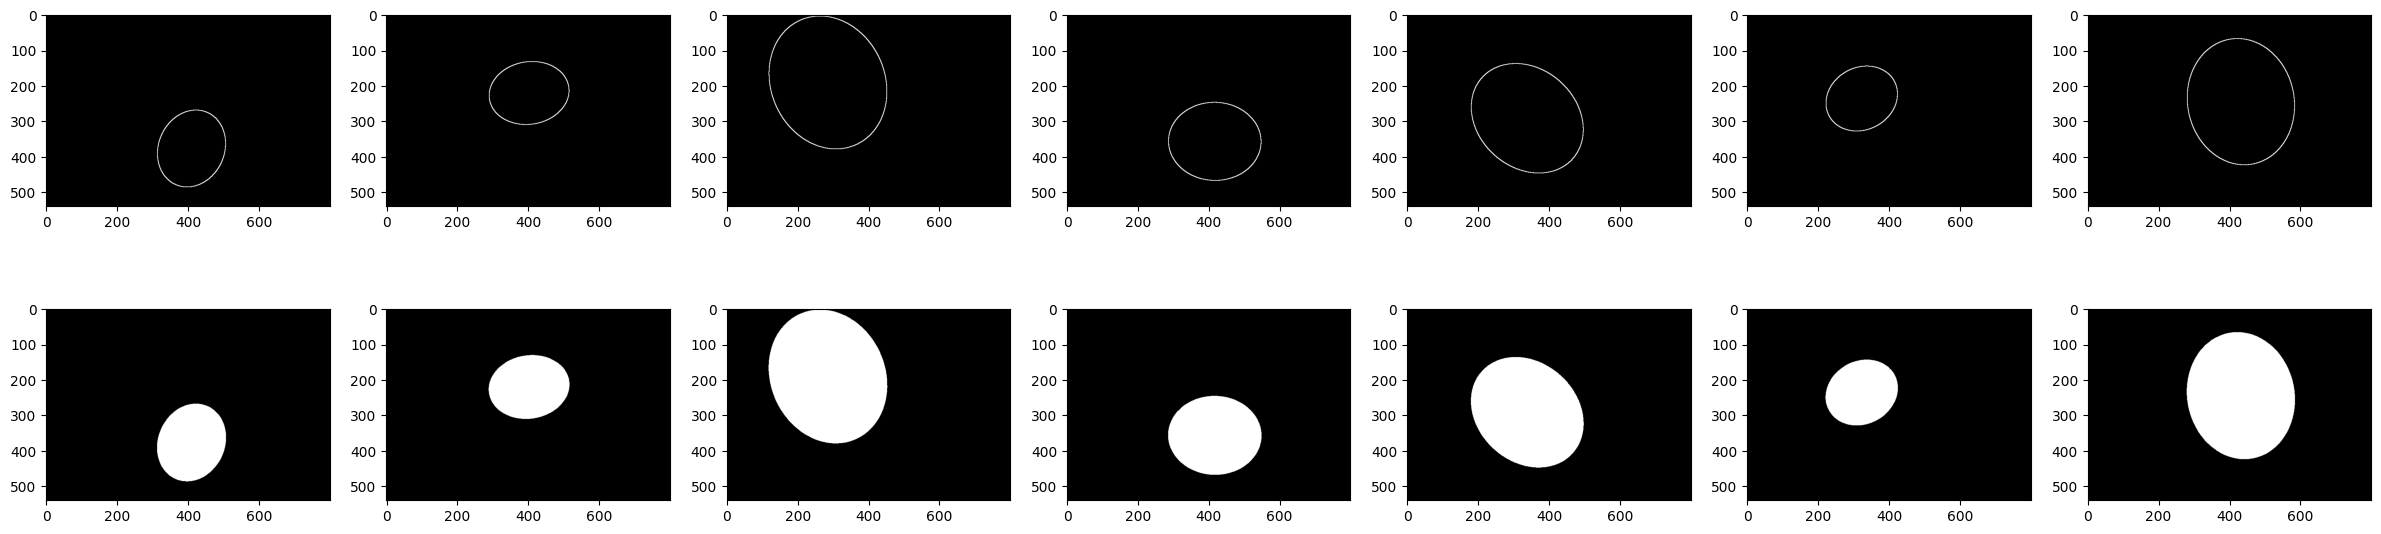

In [ ]:
# to check if our masking function is working correctly
fig = plt.figure(figsize = (30,7))
for index in range(7):
  file_path = os.path.join('/content/drive/MyDrive/MLinMed/Data/Practice2/training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
  print(file_path)
  ax = fig.add_subplot(2, 7, index+1)             ## annoted plot
  plt.imshow(cv2.imread(file_path))

  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(masking(cv2.imread(file_path)))        ## mask plot

In [ ]:
# # Loop through training set and  take annotations one by one and replace them with corresponding masks
# for index in range(len(train_pixel_file)):
#     file_path = os.path.join('/content/drive/MyDrive/MLinMed/Data/Practice2/training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
#     image = cv2.imread(file_path)
#     mask = masking(image)

#     # Generate a new filename for the mask
#     new_file_path = file_path.replace('_Annotation.png', '_Mask.png')

#     # Save the mask with the new filename
#     cv2.imwrite(new_file_path, mask)

### **Model**

In [ ]:
# Define image size
IMG_SIZE = (256, 256)

# Function to load and preprocess images and masks
def load_data(image_folder):
    images = []
    masks = []

    for file in os.listdir(image_folder):
        if file.endswith("_HC.png"):
            img_path = os.path.join(image_folder, file)
            mask_path = os.path.join(image_folder, file.replace("_HC.png", "_HC_Mask.png"))

            if os.path.exists(mask_path):
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, IMG_SIZE)
                image = image.astype(np.float32) / 255.0  # Normalize
                image = np.expand_dims(image, axis=-1)  # Add channel dimension

                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, IMG_SIZE)
                mask = (mask > 0).astype(np.uint8)  # Convert to binary mask
                mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

                images.append(image)
                masks.append(mask)

    return np.array(images), np.array(masks)

In [ ]:
# Define U-Net Model
def build_unet_model(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D((2,2))(c4)
    u5 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u5)

    u6 = layers.UpSampling2D((2,2))(c5)
    u6 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u6)

    u7 = layers.UpSampling2D((2,2))(c6)
    u7 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u7)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c7)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
image_folder = "/content/drive/MyDrive/MLinMed/Data/Practice2/training_set"

# Load dataset
X_train, Y_train = load_data(image_folder)

# Build and compile model
model = build_unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

# Train model
model.fit(X_train, Y_train, epochs=20, batch_size=2, validation_split=0.2)

# Save trained model
model.save("/content/drive/MyDrive/MLinMed/Data/Practice2/fetal_head_segmentation_model.h5")
model.save("/content/drive/MyDrive/MLinMed/Data/Practice2/fetal_head_segmentation_model.keras")

Epoch 1/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 705s 2s/step - loss: 0.5628 - mae: 0.3832 - val_loss: 0.3040 - val_mae: 0.2045
Epoch 2/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 749s 2s/step - loss: 0.3388 - mae: 0.2205 - val_loss: 0.3048 - val_mae: 0.1930
Epoch 3/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 742s 2s/step - loss: 0.3192 - mae: 0.2074 - val_loss: 0.2737 - val_mae: 0.1779
Epoch 4/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 735s 2s/step - loss: 0.2916 - mae: 0.1884 - val_loss: 0.2429 - val_mae: 0.1753
Epoch 5/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 746s 2s/step - loss: 0.2350 - mae: 0.1475 - val_loss: 0.1273 - val_mae: 0.0731
Epoch 6/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 737s 2s/step - loss: 0.1566 - mae: 0.0937 - val_loss: 0.0824 - val_mae: 0.0431
Epoch 7/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 738s 2s/step - loss: 0.1254 - mae: 0.0736 - val_loss: 0.0743 - val_mae: 0.0495
Epoch 8/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - loss: 0.1076 - mae: 0.0644 - val_loss: 0.0671 - val_mae: 0.0411
Epoch 9/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 735s 2s/

### Segmentation on test_set

In [ ]:
def load_test_data(image_folder):
    images = []
    filenames = []

    for file in os.listdir(image_folder):
        if file.endswith("_HC.png"):
            img_path = os.path.join(image_folder, file)
            filenames.append(file)

            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, IMG_SIZE)
            image = image.astype(np.float32) / 255.0  # Normalize
            image = np.expand_dims(image, axis=-1)  # Add channel dimension

            images.append(image)

    return np.array(images), filenames

In [ ]:
# Function to draw ellipse and find head circumference
def find_head_circumference(mask, original_image):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        ellipse = cv2.fitEllipse(largest_contour)

        # Draw ellipse on original image
        output_image = original_image.copy()
        cv2.ellipse(output_image, ellipse, (0, 255, 0), 2)

        # Calculate major and minor axes
        (x, y), (major_axis, minor_axis), angle = ellipse
        head_circumference = np.pi * (3 * (major_axis + minor_axis) - np.sqrt((3 * major_axis + minor_axis) * (major_axis + 3 * minor_axis)))

        return output_image, head_circumference
    return original_image, None

In [ ]:
image_folder = "/content/drive/MyDrive/MLinMed/Data/Practice2/test_set"

# Load test dataset
X_test, filenames = load_test_data(image_folder)

# Load trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/MLinMed/Data/Practice2/fetal_head_segmentation_model.keras")

# Predict segmentation masks
predicted_masks = model.predict(X_test)
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)  # Threshold to binary mask

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 32 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


11/11 ━━━━━━━━━━━━━━━━━━━━ 95s 8s/step


In [ ]:
for i, filename in enumerate(filenames):
    original_image = cv2.imread(os.path.join(image_folder, filename), cv2.IMREAD_GRAYSCALE)
    original_image = cv2.resize(original_image, IMG_SIZE)
    segmented_mask = predicted_masks[i].squeeze() * 255  # Convert mask to display format

    # Draw ellipse and compute head circumference
    output_image, head_circumference = find_head_circumference(segmented_mask, original_image)

    # Show result
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")

    plt.subplot(1,2,2)
    plt.imshow(output_image, cmap='gray')
    plt.title(f"Predicted Mask with Ellipse\nHC: {head_circumference:.2f} mm" if head_circumference else "No Ellipse Detected")

    plt.show()